# Codealong: PCA, Pipelines & Model persistance

PCA technique is particularly useful in processing data where multi-colinearity exists between the features/variables. 

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
# reading
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/housing_prices.csv") 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = df.set_index('Id')
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [43]:
#data.columns
df['MSZoning'].apply(str)


Id
1       RL
2       RL
3       RL
4       RL
5       RL
        ..
1456    RL
1457    RL
1458    RL
1459    RL
1460    RL
Name: MSZoning, Length: 1460, dtype: object

## Train-test split

In [7]:
y = df['SalePrice'].copy()
X = df.drop(columns=['SalePrice']).copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=1230000)

In [9]:
# copy of train_X and test_X
train_X_original = X_train.copy()
test_X_original = X_test.copy()

## Pre-processing

In [10]:
# copy of train_X and test_X
X_num_col = X_train.select_dtypes(include="number").copy().columns
X_cat_col = X_train.select_dtypes(exclude="number").copy().columns

num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler())
    #StandardScaler())

cat_pipe = make_pipeline(
    #SimpleImputer(strategy="constant", fill_value='NaN'),
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False))
    #OneHotEncoder(drop="first"))


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", num_pipe, X_num_col),
        ("cat_pipe", cat_pipe, X_cat_col)
]
)

In [12]:
full_pipeline = make_pipeline(preprocessor)
full_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1st...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'G

In [13]:
X_train_cleaned = full_pipeline.transform(X_train)
X_train_cleaned

array([[0.14705882, 0.12671233, 0.02374442, ..., 0.        , 1.        ,
        0.        ],
       [0.23529412, 0.16438356, 0.03131646, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.18493151, 0.04370282, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.37328767, 0.04747482, ..., 0.        , 1.        ,
        0.        ],
       [0.05882353, 0.03082192, 0.01837856, ..., 0.        , 1.        ,
        0.        ],
       [0.17647059, 0.09931507, 0.03320947, ..., 0.        , 1.        ,
        0.        ]])

In [14]:
X_test_cleaned = full_pipeline.transform(X_test)
X_test_cleaned

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5, 14, 15, 27] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


array([[0.23529412, 0.19863014, 0.05374278, ..., 0.        , 1.        ,
        0.        ],
       [0.05882353, 0.15753425, 0.03494823, ..., 0.        , 1.        ,
        0.        ],
       [0.23529412, 0.15068493, 0.03225128, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.17647059, 0.13013699, 0.07088738, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.19863014, 0.04201547, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.20205479, 0.03879502, ..., 0.        , 1.        ,
        0.        ]])

## Modelling (iteration 1)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
neigh1 = KNeighborsClassifier()

param_distribs=({"n_neighbors": randint(low=3, high=30),
                "weights":["uniform", "distance"],
                "p":[1,2]})

neigh1_search = RandomizedSearchCV(neigh1,
                                   param_distribs,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=4,
                                   random_state=123)

neigh1_search.fit(X_train_cleaned, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(round(neigh1_search.best_score_, 2))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


--- 12.903897285461426 seconds ---
0.01


In [18]:
%%time

print("status")

status
CPU times: user 73 µs, sys: 12 µs, total: 85 µs
Wall time: 88.9 µs


## PCA

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10) # pick number of components 
X_reduced = pca.fit_transform(X_train_cleaned)

In [20]:
X_reduced.shape

(1168, 10)

In [21]:
pd.DataFrame(X_reduced)

,0,1,2,3,4,5,6,7,8,9
0,-2.074030,1.472893,0.074446,0.461139,0.156116,0.413742,0.016351,0.408015,0.082333,-0.262295
1,0.425739,-0.401364,1.710156,-0.373793,-0.177602,0.436272,0.372161,-0.118374,-0.295886,-0.528211
2,-1.358385,-1.074139,-0.391031,-0.718989,0.085906,0.534369,0.423955,-0.716758,0.140880,0.972191
3,2.241771,-0.059353,1.148858,0.422679,-0.156507,0.163799,-0.761763,-0.310941,-0.094293,-0.567000
4,2.051366,-0.183911,0.075034,-1.255646,-0.193805,0.029401,-0.848228,0.324099,-0.194562,-0.409444
...,...,...,...,...,...,...,...,...,...,...
1163,-1.029752,-0.417498,-0.734635,-0.744621,-0.980797,-0.319274,-0.129447,-0.408518,1.095896,-0.132561
1164,0.063375,-0.131334,-0.162301,-0.559281,0.448918,0.053661,-0.402182,0.475290,0.243029,-0.238103
1165,0.094162,-1.400093,0.551970,-1.196116,0.954209,0.155416,0.426432,-0.152212,-0.201050,0.904154
1166,-1.605719,1.622831,-0.285474,-0.465855,0.389234,-0.744079,0.005085,-0.184315,-1.025153,0.132265


## Modelling (iteration 2)

In [22]:
start_time = time.time()
neigh2 = KNeighborsClassifier()

neigh2_search = RandomizedSearchCV(neigh2,
                                   param_distribs,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=4,
                                   random_state=123)

neigh2_search.fit(X_reduced, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(round(neigh2_search.best_score_, 2))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


--- 4.677974700927734 seconds ---
0.01


### Picking the right number of components

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None) # pick number of components
X_reduced = pca.fit_transform(X_train_cleaned)

In [24]:
np.round(pca.explained_variance_ratio_, 4)*100

array([1.648e+01, 6.550e+00, 4.530e+00, 3.210e+00, 2.980e+00, 2.880e+00,
       2.550e+00, 2.380e+00, 2.300e+00, 2.150e+00, 2.110e+00, 1.850e+00,
       1.790e+00, 1.770e+00, 1.660e+00, 1.560e+00, 1.550e+00, 1.360e+00,
       1.310e+00, 1.270e+00, 1.200e+00, 1.170e+00, 1.090e+00, 1.030e+00,
       1.010e+00, 9.300e-01, 9.000e-01, 8.800e-01, 8.400e-01, 8.100e-01,
       7.900e-01, 7.800e-01, 7.600e-01, 7.000e-01, 6.800e-01, 6.500e-01,
       6.200e-01, 6.100e-01, 5.900e-01, 5.700e-01, 5.500e-01, 5.300e-01,
       5.200e-01, 5.100e-01, 5.000e-01, 4.800e-01, 4.700e-01, 4.500e-01,
       4.300e-01, 4.100e-01, 4.000e-01, 3.900e-01, 3.800e-01, 3.700e-01,
       3.600e-01, 3.500e-01, 3.500e-01, 3.400e-01, 3.300e-01, 3.200e-01,
       3.000e-01, 2.900e-01, 2.900e-01, 2.800e-01, 2.700e-01, 2.700e-01,
       2.700e-01, 2.500e-01, 2.500e-01, 2.500e-01, 2.400e-01, 2.400e-01,
       2.300e-01, 2.300e-01, 2.200e-01, 2.200e-01, 2.100e-01, 2.100e-01,
       2.000e-01, 2.000e-01, 2.000e-01, 1.900e-01, 

In [25]:
# compute the cumulative sum of explained variance ratio

# create a plot to visualize the cumulative sum of explained variance
# as the number of principal components increases

# How much variance do you want to keep in the data?
# How many components (dimensions) should you drop, considering computing power, the curse of dimensionality, overfitting..?

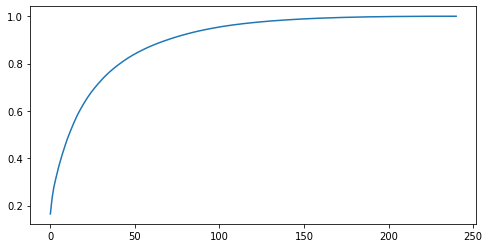

In [26]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cumsum, label = "Explained variance");

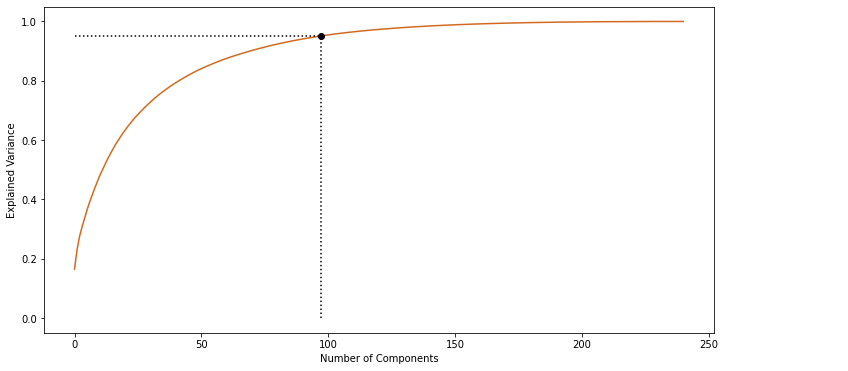

In [27]:
import matplotlib.pyplot as plt

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)

# create first figure and ax
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumsum, label = "Explained variance", c="chocolate")

ax.annotate("Elbow?", xy=(270, 0.92), xytext=(280, 0.75),
             arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.plot([d, d], [0, 0.95], "k:")
ax.plot([0, d], [0.95, 0.95], "k:")
ax.plot(d, 0.95, "ko")

ax.set_ylabel("Explained Variance")
ax.set_xlabel("Number of Components");

# Pre-processing + model pipeline

`make_pipeline()` is almost identical to `Pipeline()`: you can call as many transformers as you want (you don't even need to initialize them before) sequentially. Then, you can use fit(), transform() or fit_transform() as if it was only a single transformer.

`make_pipeline()` does't require explicit naming of the steps (generates the names automatically) - it can be used when we don't care about the names and simply want to create a quick pipeline.

In both cases, a model can be added at the end of the pipeline. You can then call the `fit()` method to the pipeline to apply all the transformations and fit the model, passing the X and y of the training set as arguments.

A pipeline with a model also has the `predict()` method available. Passing an X to that method (either the train or the test) will transform the data and output predictions.

#### Pre-processing pipeline

In [28]:
train_X_2 = train_X_original.copy()
test_X_2 = test_X_original.copy()

In [41]:
from sklearn.pipeline import make_pipeline

param_distribs={"n_neighbors": randint(low=3, high=30),
                "weights":["uniform", "distance"],
                "p":[1,2]}

neigh3_search = RandomizedSearchCV(KNeighborsClassifier(),
                                   param_distribs,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=4,
                                   random_state=123)


model_pipeline = make_pipeline(StandardScaler(),
                                 PCA(n_components=0.98),
                                 neigh3_search)

In [30]:
X_train_cleaned1 = full_pipeline.transform(train_X_2)

In [ ]:
model_pipeline.fit(X_train_cleaned1, y_train)

You can still access the randomized search cv scores, parameters...

In [32]:
model_pipeline["randomizedsearchcv"].best_score_

0.014551923993984079

In [33]:
model_pipeline["randomizedsearchcv"].best_params_

{'n_neighbors': 21, 'p': 2, 'weights': 'distance'}

### Cross validation: tuning the parameters in the pipeline

Some transformers in the pipeline

In [34]:
train_X_3 = train_X_original.copy()
test_X_3 = test_X_original.copy()

In [35]:
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline([("scaler", StandardScaler()),
                          ("pca", PCA()),
                          ("neigh", KNeighborsClassifier())])

param_grid = {
    "pca__n_components": [10, 30, 50, 100],
    "neigh__n_neighbors": [3, 15, 50, 80, 150]
}

In [36]:
neigh3_search = RandomizedSearchCV(model_pipeline,
                                   param_grid,
                                   scoring="accuracy",
                                   n_iter=10,
                                   cv=5,
                                   n_jobs=4,
                                   random_state=123)

In [37]:
X_train_cleaned2 = full_pipeline.transform(train_X_3)

In [ ]:
neigh3_search.fit(X_train_cleaned2, y_train)

In [39]:
neigh3_search.best_params_

{'neigh__n_neighbors': 50, 'pca__n_components': 10}

In [40]:
neigh3_search.best_score_

0.019702138586258754